# Experiment: Compare Prev Viol Mask Stim Average

**Goal:** Based on a comment made by Emily at lab meeting, see if unmasking previous stim average on prev violation trials leads to a better fit. 

Her comment was that we don't know how much of the stim the animal heard, perhaps that could cause them to violate more/be biased etc. 

Long term, would want to have violations conditioned on what was heard- sa, sb, neither or both.

*side note*: this is the first NB going forward that uses the new design matrix generator class.

> Written by Jess Breda


In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

from multiglm.experiments.experiment import load_experiment

from multiglm.experiments.experiment_compare_models import ExperimentCompareModels

from multiglm.features.design_matrix_generator import *
from multiglm.features.design_matrix_generator_PWM import *

from multiglm.models.multiclass_logistic_regression import MultiClassLogisticRegression

from multiglm.visualizations.model_visualizer import ModelVisualizerCompare

from multiglm.data import ANIMAL_IDS
from multiglm.experiments import STANDARD_SIGMAS

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

## Models Configs

In [2]:
# design matrix columns shared between all models being fit
shared_cols = {
    "session": lambda df: (copy(df.session)),
    "bias": lambda df: (add_bias_column(df)),
    "s_a": lambda df: (standardize(df.s_a)),
    "s_b": lambda df: (standardize(df.s_b)),
    "prev_correct": lambda df: (prev_correct_side(df)),
    "prev_choice": lambda df: (prev_choice(df)),
    "prev_violation_filt": lambda df: (
        filtered_prev_viol(df, get_animals_tau(df, "prev_violation"))
    ),
    "labels": {"column_name": "choice"},
}

models_config = {
    "prev_stim_w_viol_mask": {
        "model_class": MultiClassLogisticRegression,
        "dmg_config": {
            **shared_cols,
            "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=True),
        },
    },
    "prev_stim_wo_viol_mask": {
        "model_class": MultiClassLogisticRegression,
        "dmg_config": {
            **shared_cols,
            "prev_avg_stim": lambda df: prev_avg_stim(df, mask_prev_violation=False),
        },
    },
}

params = {
    "animals": ANIMAL_IDS,
    "data_type": "new_trained",
    "sigmas": STANDARD_SIGMAS,
    "random_state": 47,
    "eval_train": True,
    "null_mode": "multi",
    "model_config": models_config,
}

ORDER = ["prev_stim_w_viol_mask", "prev_stim_wo_viol_mask"]

save_name = "2024_03_19_compare_prev_viol_mask_stim_avg.pkl"

In [3]:
experiment = ExperimentCompareModels(params)
experiment.run()
experiment.save(save_name)

Loading dataset type : new_trained
Loading data for animal ids:  ['W051', 'W060', 'W065', 'W066', 'W068', 'W072', 'W073', 'W074', 'W075', 'W078', 'W080', 'W081', 'W082', 'W083', 'W088', 'W089', 'W094']

 >>>> evaluating animal W051 <<<<

 ***** evaluating model prev_stim_w_viol_mask w/ sigma 0.07 *****
Optimization terminated successfully.
         Current function value: 64772.423027
         Iterations: 26
         Function evaluations: 37
         Gradient evaluations: 37

 ***** evaluating model prev_stim_w_viol_mask w/ sigma 0.13 *****
         Current function value: 64482.383639
         Iterations: 26
         Function evaluations: 38
         Gradient evaluations: 38

 ***** evaluating model prev_stim_w_viol_mask w/ sigma 0.25 *****
Optimization terminated successfully.
         Current function value: 64388.728385
         Iterations: 25
         Function evaluations: 36
         Gradient evaluations: 36

 ***** evaluating model prev_stim_w_viol_mask w/ sigma 0.5 *****
      

In [4]:
experiment.save(save_name)

## Visualize

In [5]:
# experiment = load_experiment(save_name)
mvc = ModelVisualizerCompare(experiment)

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_25145/2431235986.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for model_name, model_df in df.groupby("model_name"):
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current beh

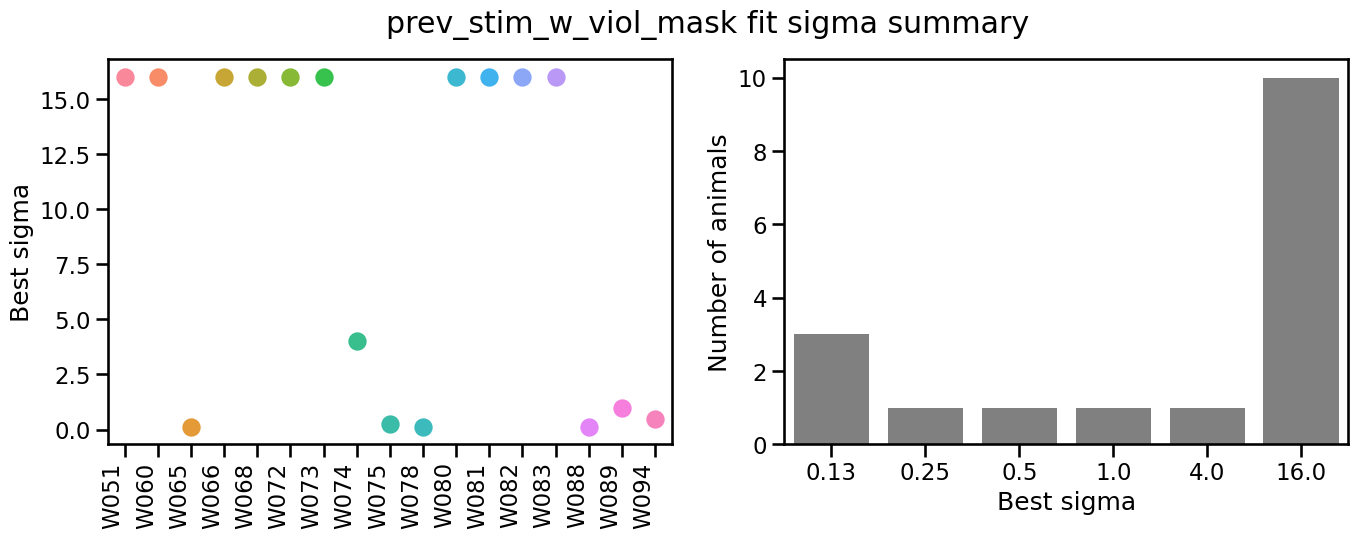

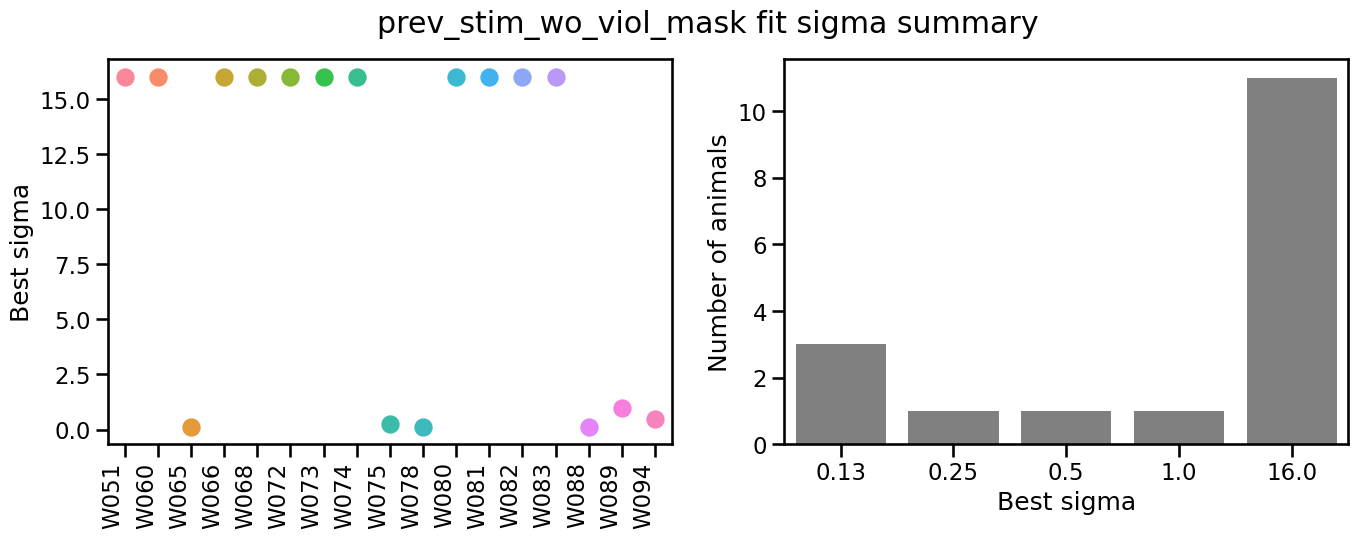

In [6]:
df = mvc.find_best_fit(group="model_name")
df["model_name"] = pd.Categorical(df["model_name"], categories=ORDER, ordered=True)
for model_name, model_df in df.groupby("model_name"):
    mvc.plot_sigma_summary(model_df, title=f"{model_name} fit sigma summary")

/var/folders/__/8jn6qz211155h1xb451s5zcr0000gn/T/ipykernel_25145/2667047998.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):


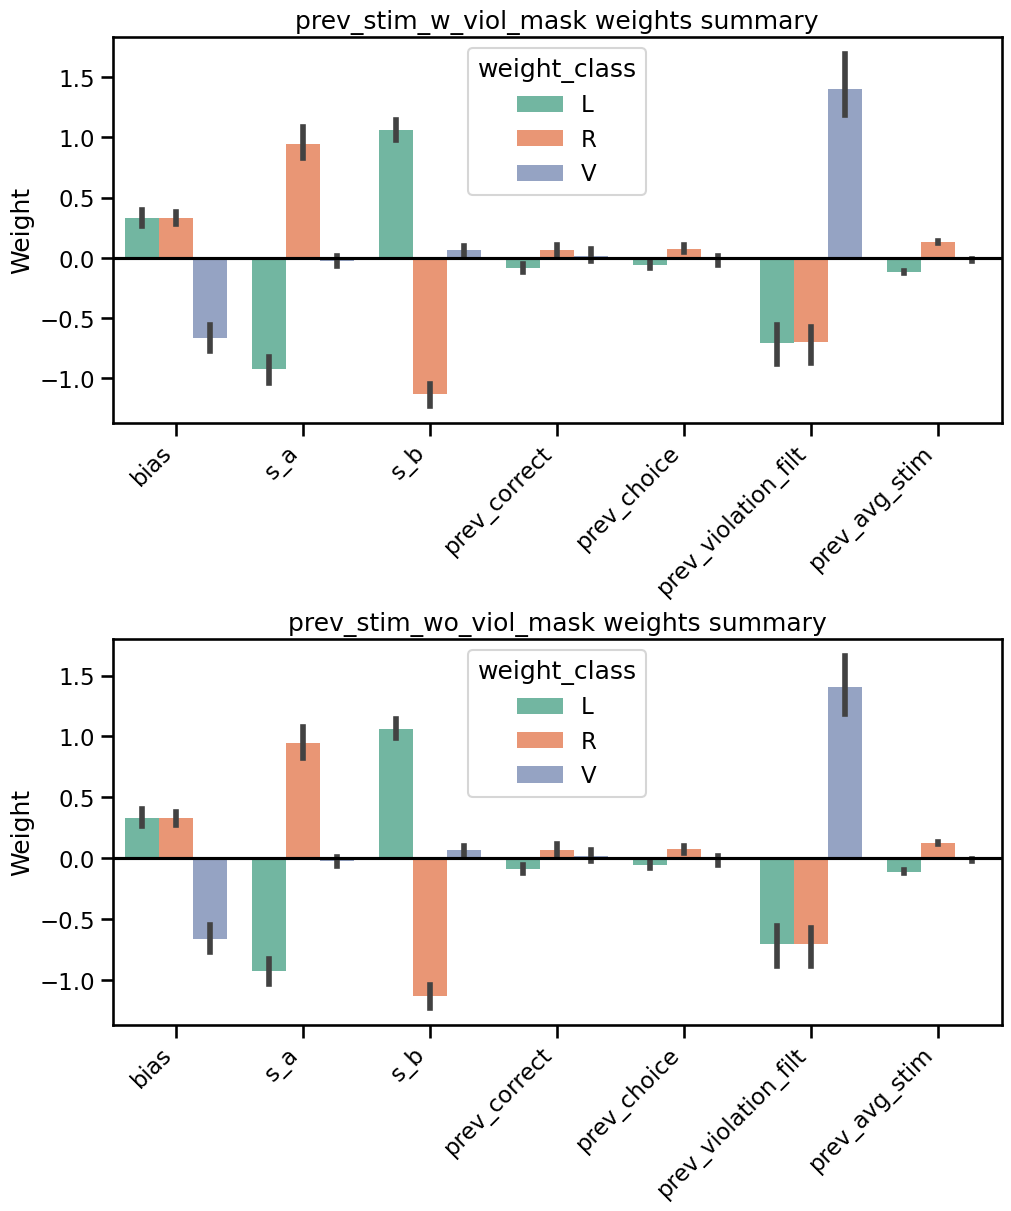

In [7]:
fig, ax = plt.subplots(
    len(ORDER), 1, figsize=(10, len(ORDER) * 6), constrained_layout=True, sharey=False
)

best_fit_by_model = mvc.find_best_fit(group=["animal_id", "model_name"])
best_fit_by_model["model_name"] = pd.Categorical(
    best_fit_by_model["model_name"], categories=ORDER, ordered=True
)

for ii, (model_name, model_df) in enumerate(best_fit_by_model.groupby("model_name")):
    unpacked = mvc.unpack_features_and_weights(model_df)

    mvc.plot_weights_summary(
        df=unpacked,
        ax=ax[ii],
        palette="Set2",
        title=f"{model_name} weights summary",
    )

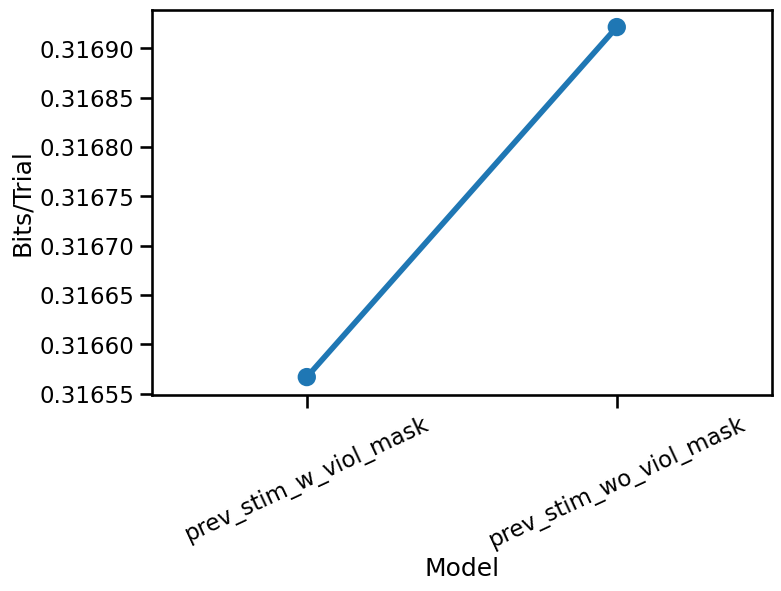

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
mvc.plot_model_comparison(
    hue=None,
    ax=ax,
    order=ORDER,
    errorbar=None,
)

/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/Users/jessbreda/anaconda3/envs/an_lrn/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


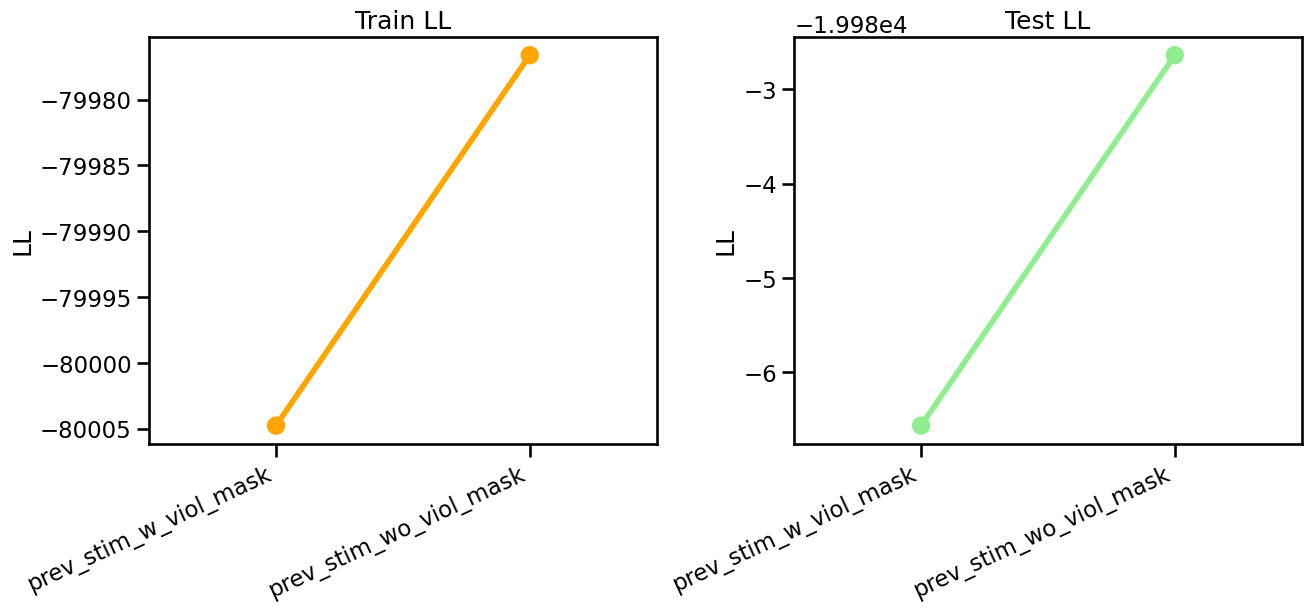

In [9]:
mvc.plot_train_and_test_ll(
    order=ORDER,
    errorbar=None,
)

<Axes: title={'center': 'Model Improvement- mu: 3.93 std: 8.63 \n prev_stim_w_viol_mask -> prev_stim_wo_viol_mask'}, xlabel='animal_id', ylabel='Delta test LL (new - base)'>

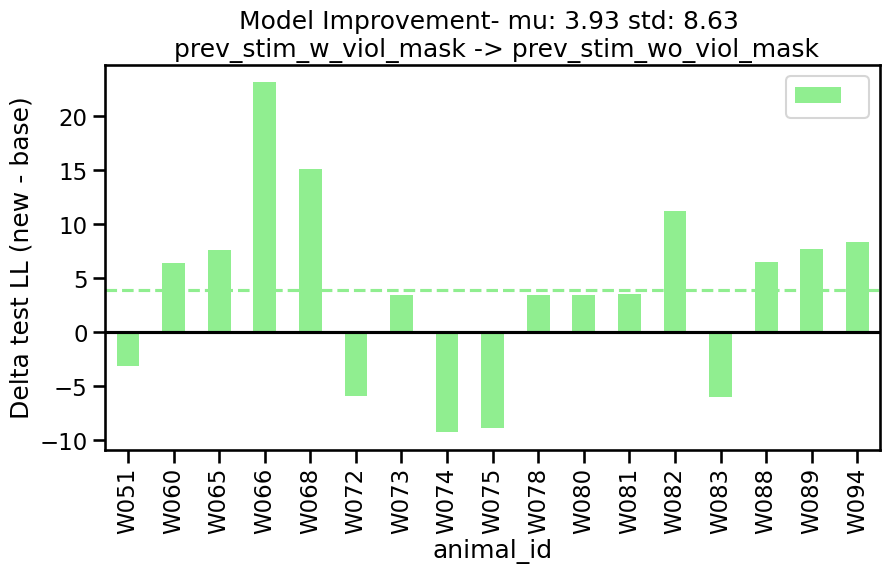

In [10]:
mvc.plot_ll_delta_by_animal(
    base_model_name=ORDER[0],
    new_model_name=ORDER[1],
    type="test",
)